## **El Niño Analysis Using PySpark for Predicting Sea Surface Temperature**

Annisaa Fitri Nurfirdausi - 0001110915

## **1. PySpark Set Up and Data Inspection**

We initialize a PySpark SparkSession to process data locally with all available CPU cores. It reads the elnino.csv dataset, inferring schema and using the first row as headers. The schema of the dataset is printed, and the first 5 rows are displayed for inspection.

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master("spark://localhost:7077") \
    .appName("ElNino") \
    .config("spark.executor.memory", "1g") \
    .config("spark.driver.memory", "1g") \
    .config("spark.executor.cores", "2") \
    .config("spark.sql.shuffle.partitions", "2") \
    .getOrCreate()


df = spark.read.csv('elnino.csv', header=True, inferSchema=True)
df.printSchema()
df.show(5)


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/14 12:42:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/12/14 12:42:53 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


root
 |-- obs: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- date: integer (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- zon.winds: string (nullable = true)
 |-- mer.winds: string (nullable = true)
 |-- humidity: string (nullable = true)
 |-- air temp.: string (nullable = true)
 |-- s.s.temp.: string (nullable = true)

+---+----+-----+---+------+--------+---------+---------+---------+--------+---------+---------+
|obs|year|month|day|  date|latitude|longitude|zon.winds|mer.winds|humidity|air temp.|s.s.temp.|
+---+----+-----+---+------+--------+---------+---------+---------+--------+---------+---------+
|  1|  80|    3|  7|800307|   -0.02|  -109.46|     -6.8|      0.7|       .|    26.14|    26.24|
|  2|  80|    3|  8|800308|   -0.02|  -109.46|     -4.9|      1.1|       .|    25.66|    25.97|
|  3|  80|    3|  9|800309|   -0.02|  -109.46

In [3]:
num_rows = df.count()
print(f' there are {num_rows} rows in the dataset')

 there are 178080 rows in the dataset


We rename the columns in the DataFrame to more readable names

In [4]:
new_column_names = {
    'obs': 'observation',
    'year': 'year',
    'month': 'month',
    'day': 'day',
    'date': 'date',
    'latitude': 'latitude',
    'longitude': 'longitude',
    'zon.winds': 'zonal_winds',
    'mer.winds': 'meridional_winds',
    'humidity': 'humidity',
    'air temp.': 'air_temperature',
    's.s.temp.': 'sea_surface_temperature'
}

for old_name, new_name in new_column_names.items():
    df = df.withColumnRenamed(old_name, new_name)

We would like to convert the time variables (year, month, day, date) into a 'date' format to make it easier to perform time-based operations, such as filtering, grouping by date, and plotting over time.

In [6]:
from pyspark.sql.functions import col, concat_ws, to_date, when, lpad

df = df.withColumn("year", when(col("year") < 100, col("year") + 1900).otherwise(col("year")))
df = df.withColumn("month", lpad(col("month"), 2, "0"))
df = df.withColumn("day", lpad(col("day"), 2, "0"))
df = df.withColumn("date", to_date(concat_ws("-", col("year"), col("month"), col("day"))))

df = df.drop("year", "month", "day")

df.show()


AnalysisException: [UNRESOLVED_COLUMN.WITH_SUGGESTION] A column or function parameter with name `year` cannot be resolved. Did you mean one of the following? [`date`, `latitude`, `humidity`, `longitude`, `observation`].;
'Project [observation#129, date#324, latitude#194, longitude#207, zonal_winds#220, meridional_winds#233, humidity#246, air_temperature#259, sea_surface_temperature#272, CASE WHEN ('year < 100) THEN ('year + 1900) ELSE 'year END AS year#394]
+- Project [observation#129, date#324, latitude#194, longitude#207, zonal_winds#220, meridional_winds#233, humidity#246, air_temperature#259, sea_surface_temperature#272]
   +- Project [observation#129, year#285, month#298, day#311, to_date(concat_ws(-, cast(year#285 as string), month#298, day#311), None, Some(Europe/Rome), false) AS date#324, latitude#194, longitude#207, zonal_winds#220, meridional_winds#233, humidity#246, air_temperature#259, sea_surface_temperature#272]
      +- Project [observation#129, year#285, month#298, lpad(cast(day#168 as string), 2, 0) AS day#311, date#181, latitude#194, longitude#207, zonal_winds#220, meridional_winds#233, humidity#246, air_temperature#259, sea_surface_temperature#272]
         +- Project [observation#129, year#285, lpad(cast(month#155 as string), 2, 0) AS month#298, day#168, date#181, latitude#194, longitude#207, zonal_winds#220, meridional_winds#233, humidity#246, air_temperature#259, sea_surface_temperature#272]
            +- Project [observation#129, CASE WHEN (year#142 < 100) THEN (year#142 + 1900) ELSE year#142 END AS year#285, month#155, day#168, date#181, latitude#194, longitude#207, zonal_winds#220, meridional_winds#233, humidity#246, air_temperature#259, sea_surface_temperature#272]
               +- Project [observation#129, year#142, month#155, day#168, date#181, latitude#194, longitude#207, zonal_winds#220, meridional_winds#233, humidity#246, air_temperature#259, s.s.temp.#28 AS sea_surface_temperature#272]
                  +- Project [observation#129, year#142, month#155, day#168, date#181, latitude#194, longitude#207, zonal_winds#220, meridional_winds#233, humidity#246, air temp.#27 AS air_temperature#259, s.s.temp.#28]
                     +- Project [observation#129, year#142, month#155, day#168, date#181, latitude#194, longitude#207, zonal_winds#220, meridional_winds#233, humidity#26 AS humidity#246, air temp.#27, s.s.temp.#28]
                        +- Project [observation#129, year#142, month#155, day#168, date#181, latitude#194, longitude#207, zonal_winds#220, mer.winds#25 AS meridional_winds#233, humidity#26, air temp.#27, s.s.temp.#28]
                           +- Project [observation#129, year#142, month#155, day#168, date#181, latitude#194, longitude#207, zon.winds#24 AS zonal_winds#220, mer.winds#25, humidity#26, air temp.#27, s.s.temp.#28]
                              +- Project [observation#129, year#142, month#155, day#168, date#181, latitude#194, longitude#23 AS longitude#207, zon.winds#24, mer.winds#25, humidity#26, air temp.#27, s.s.temp.#28]
                                 +- Project [observation#129, year#142, month#155, day#168, date#181, latitude#22 AS latitude#194, longitude#23, zon.winds#24, mer.winds#25, humidity#26, air temp.#27, s.s.temp.#28]
                                    +- Project [observation#129, year#142, month#155, day#168, date#21 AS date#181, latitude#22, longitude#23, zon.winds#24, mer.winds#25, humidity#26, air temp.#27, s.s.temp.#28]
                                       +- Project [observation#129, year#142, month#155, day#20 AS day#168, date#21, latitude#22, longitude#23, zon.winds#24, mer.winds#25, humidity#26, air temp.#27, s.s.temp.#28]
                                          +- Project [observation#129, year#142, month#19 AS month#155, day#20, date#21, latitude#22, longitude#23, zon.winds#24, mer.winds#25, humidity#26, air temp.#27, s.s.temp.#28]
                                             +- Project [observation#129, year#18 AS year#142, month#19, day#20, date#21, latitude#22, longitude#23, zon.winds#24, mer.winds#25, humidity#26, air temp.#27, s.s.temp.#28]
                                                +- Project [obs#17 AS observation#129, year#18, month#19, day#20, date#21, latitude#22, longitude#23, zon.winds#24, mer.winds#25, humidity#26, air temp.#27, s.s.temp.#28]
                                                   +- Relation [obs#17,year#18,month#19,day#20,date#21,latitude#22,longitude#23,zon.winds#24,mer.winds#25,humidity#26,air temp.#27,s.s.temp.#28] csv


## **2. Feature Engineering**

On this section, we will add some new necessary variables: 
- El Nino (whether the El Nino is occured on that period)
- Ocean (whether it is located in the West Pacific or East Pacific)
- Hemisphere (whether it is located in South or North Hemisphere)

### **2.1. El Nino**

Based on the past records, El Nino happened on these period ranges:
1. Between May 1982 and June 1983 [https://www.nature.com/articles/305016a0.pdf]
2. Between May 1997 and June 1998 [https://en.wikipedia.org/wiki/1997–98_El_Niño_event]

In [7]:
from pyspark.sql import functions as F

# El Nino Period
elnino_period_1_start = F.to_date(F.lit("1982-05-01"), "yyyy-MM-dd")
elnino_period_1_end = F.to_date(F.lit("1983-06-30"), "yyyy-MM-dd")

elnino_period_2_start = F.to_date(F.lit("1997-05-01"), "yyyy-MM-dd")
elnino_period_2_end = F.to_date(F.lit("1998-06-30"), "yyyy-MM-dd")

df = df.withColumn(
    "El Nino",
    F.when(
        (df["date"] >= elnino_period_1_start) & (df["date"] <= elnino_period_1_end) |
        (df["date"] >= elnino_period_2_start) & (df["date"] <= elnino_period_2_end),
        "Yes"
    ).otherwise("No")
)

df.show(5)

+-----------+----------+--------+---------+-----------+----------------+--------+---------------+-----------------------+-------+
|observation|      date|latitude|longitude|zonal_winds|meridional_winds|humidity|air_temperature|sea_surface_temperature|El Nino|
+-----------+----------+--------+---------+-----------+----------------+--------+---------------+-----------------------+-------+
|          1|1980-03-07|   -0.02|  -109.46|       -6.8|             0.7|       .|          26.14|                  26.24|     No|
|          2|1980-03-08|   -0.02|  -109.46|       -4.9|             1.1|       .|          25.66|                  25.97|     No|
|          3|1980-03-09|   -0.02|  -109.46|       -4.5|             2.2|       .|          25.69|                  25.28|     No|
|          4|1980-03-10|   -0.02|  -109.46|       -3.8|             1.9|       .|          25.57|                  24.31|     No|
|          5|1980-03-11|   -0.02|  -109.46|       -4.2|             1.5|       .|         

### **2.2. Ocean and Hemisphere**


In [8]:
df = df.withColumn(
    'Ocean',
    F.when(
        (F.col('longitude') < -170.0) | (F.col('longitude') > 160.0), 'West Pacific'
    ).when(
        (F.col('longitude') < -70.0) & (F.col('longitude') > -120.0), 'East Pacific'))

df = df.withColumn('Hemisphere', 
                               F.when(df['latitude'] < 0.0, 'South')
                                .otherwise('North'))

df.show(5)

+-----------+----------+--------+---------+-----------+----------------+--------+---------------+-----------------------+-------+------------+----------+
|observation|      date|latitude|longitude|zonal_winds|meridional_winds|humidity|air_temperature|sea_surface_temperature|El Nino|       Ocean|Hemisphere|
+-----------+----------+--------+---------+-----------+----------------+--------+---------------+-----------------------+-------+------------+----------+
|          1|1980-03-07|   -0.02|  -109.46|       -6.8|             0.7|       .|          26.14|                  26.24|     No|East Pacific|     South|
|          2|1980-03-08|   -0.02|  -109.46|       -4.9|             1.1|       .|          25.66|                  25.97|     No|East Pacific|     South|
|          3|1980-03-09|   -0.02|  -109.46|       -4.5|             2.2|       .|          25.69|                  25.28|     No|East Pacific|     South|
|          4|1980-03-10|   -0.02|  -109.46|       -3.8|             1.9|    

In [9]:
west_pacific_south_count = df.filter((F.col('Ocean') == 'West Pacific') & (F.col('Hemisphere') == 'South')).count()
east_pacific_south_count = df.filter((F.col('Ocean') == 'East Pacific') & (F.col('Hemisphere') == 'South')).count()

print(f"Rows in West Pacific South: {west_pacific_south_count}")
print(f"Rows in East Pacific South: {east_pacific_south_count}")

Rows in West Pacific South: 27174
Rows in East Pacific South: 19013


## **3. Data Cleaning**

### **2.1. Missing Values Handling**


The missing values on the dataset was represented with "." symbol.

In [10]:
from pyspark.sql.functions import col, when, count

df = df.select([when(col(c) == ".", None).otherwise(col(c)).alias(c) for c in df.columns])

missing_values = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])
missing_values.show()


+-----------+----+--------+---------+-----------+----------------+--------+---------------+-----------------------+-------+-----+----------+
|observation|date|latitude|longitude|zonal_winds|meridional_winds|humidity|air_temperature|sea_surface_temperature|El Nino|Ocean|Hemisphere|
+-----------+----+--------+---------+-----------+----------------+--------+---------------+-----------------------+-------+-----+----------+
|          0|   0|       0|        0|      25163|           25162|   65761|          18237|                  17007|      0|86713|         0|
+-----------+----+--------+---------+-----------+----------------+--------+---------------+-----------------------+-------+-----+----------+



Previously, we noticed that there are some columns whose values are not numeric type, we need to ensure that all the values are in the type of numeric.

In [11]:
from pyspark.sql.types import FloatType
df = df.withColumn('zonal_winds', F.col('zonal_winds').cast(FloatType())) \
                   .withColumn('meridional_winds', F.col('meridional_winds').cast(FloatType())) \
                   .withColumn('humidity', F.col('humidity').cast(FloatType())) \
                   .withColumn('air_temperature', F.col('air_temperature').cast(FloatType())) \
                   .withColumn('sea_surface_temperature', F.col('sea_surface_temperature').cast(FloatType()))

df.show(5)

+-----------+----------+--------+---------+-----------+----------------+--------+---------------+-----------------------+-------+------------+----------+
|observation|      date|latitude|longitude|zonal_winds|meridional_winds|humidity|air_temperature|sea_surface_temperature|El Nino|       Ocean|Hemisphere|
+-----------+----------+--------+---------+-----------+----------------+--------+---------------+-----------------------+-------+------------+----------+
|          1|1980-03-07|   -0.02|  -109.46|       -6.8|             0.7|    NULL|          26.14|                  26.24|     No|East Pacific|     South|
|          2|1980-03-08|   -0.02|  -109.46|       -4.9|             1.1|    NULL|          25.66|                  25.97|     No|East Pacific|     South|
|          3|1980-03-09|   -0.02|  -109.46|       -4.5|             2.2|    NULL|          25.69|                  25.28|     No|East Pacific|     South|
|          4|1980-03-10|   -0.02|  -109.46|       -3.8|             1.9|    

Back to the missing values, we have a lot of missing values, especially for Humidity (which covers 30% of the whole dataset). If we drop the rows with missing values, we lose 80K (nearly 50% of the data) which leads to we might lose informations.

We will look into the column with the least missing values, which is **air_temperature** and **sea_surface_temperature**. We will fill them with average values.

In [12]:
df_clean = df

mean_air_temp = df_clean.select(F.avg('air_temperature')).collect()[0][0]
mean_sea_temp = df_clean.select(F.avg('sea_surface_temperature')).collect()[0][0]

df_clean= df_clean.fillna({'air_temperature': mean_air_temp, 'sea_surface_temperature': mean_sea_temp})


And for the winds variables: **zonal_winds** and **meridional_winds**, we will use Imputer. Since wind data may follow a cyclic or periodic pattern, we will use Imputer of most_frequent value

In [13]:
from pyspark.sql import functions as F

df_non_null_zonal_winds = df_clean.filter(df['zonal_winds'].isNotNull())
df_non_null_meridional_winds = df_clean.filter(df['meridional_winds'].isNotNull())

mode_zonal_winds = df_non_null_zonal_winds.groupBy('zonal_winds').count().orderBy(F.desc('count')).first()
mode_meridional_winds = df_non_null_meridional_winds.groupBy('meridional_winds').count().orderBy(F.desc('count')).first()

mode_zonal_winds = mode_zonal_winds[0] if mode_zonal_winds else 0.0
mode_meridional_winds = mode_meridional_winds[0] if mode_meridional_winds else 0.0

df_clean = df_clean.fillna({'zonal_winds': mode_zonal_winds, 'meridional_winds': mode_meridional_winds})


In [14]:
missing_values = df_clean.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])

missing_values.show()

+-----------+----+--------+---------+-----------+----------------+--------+---------------+-----------------------+-------+-----+----------+
|observation|date|latitude|longitude|zonal_winds|meridional_winds|humidity|air_temperature|sea_surface_temperature|El Nino|Ocean|Hemisphere|
+-----------+----+--------+---------+-----------+----------------+--------+---------------+-----------------------+-------+-----+----------+
|          0|   0|       0|        0|          0|               0|   65761|              0|                      0|      0|86713|         0|
+-----------+----+--------+---------+-----------+----------------+--------+---------------+-----------------------+-------+-----+----------+



It is the Humidity now that is left. According to the dataset the relative humidity values in the tropical Pacific were typically between 70% and 90%. Since the humidity has inverse relationship on the SST and the temperature change has an important impact on humidity [https://www.mdpi.com/2073-4433/13/10/1718], we can't drop the humidity column. We will then try to drop rows with the missing values (65k data).

In [15]:
df_clean = df_clean.filter(col("humidity").isNotNull())
num_rows = df_clean.count()
print(f'There are {num_rows} rows in the dataset after removing rows with null humidity')

There are 112319 rows in the dataset after removing rows with null humidity


## **4. Exploratory Data Analysis**

### **4.1. Data Distribution**

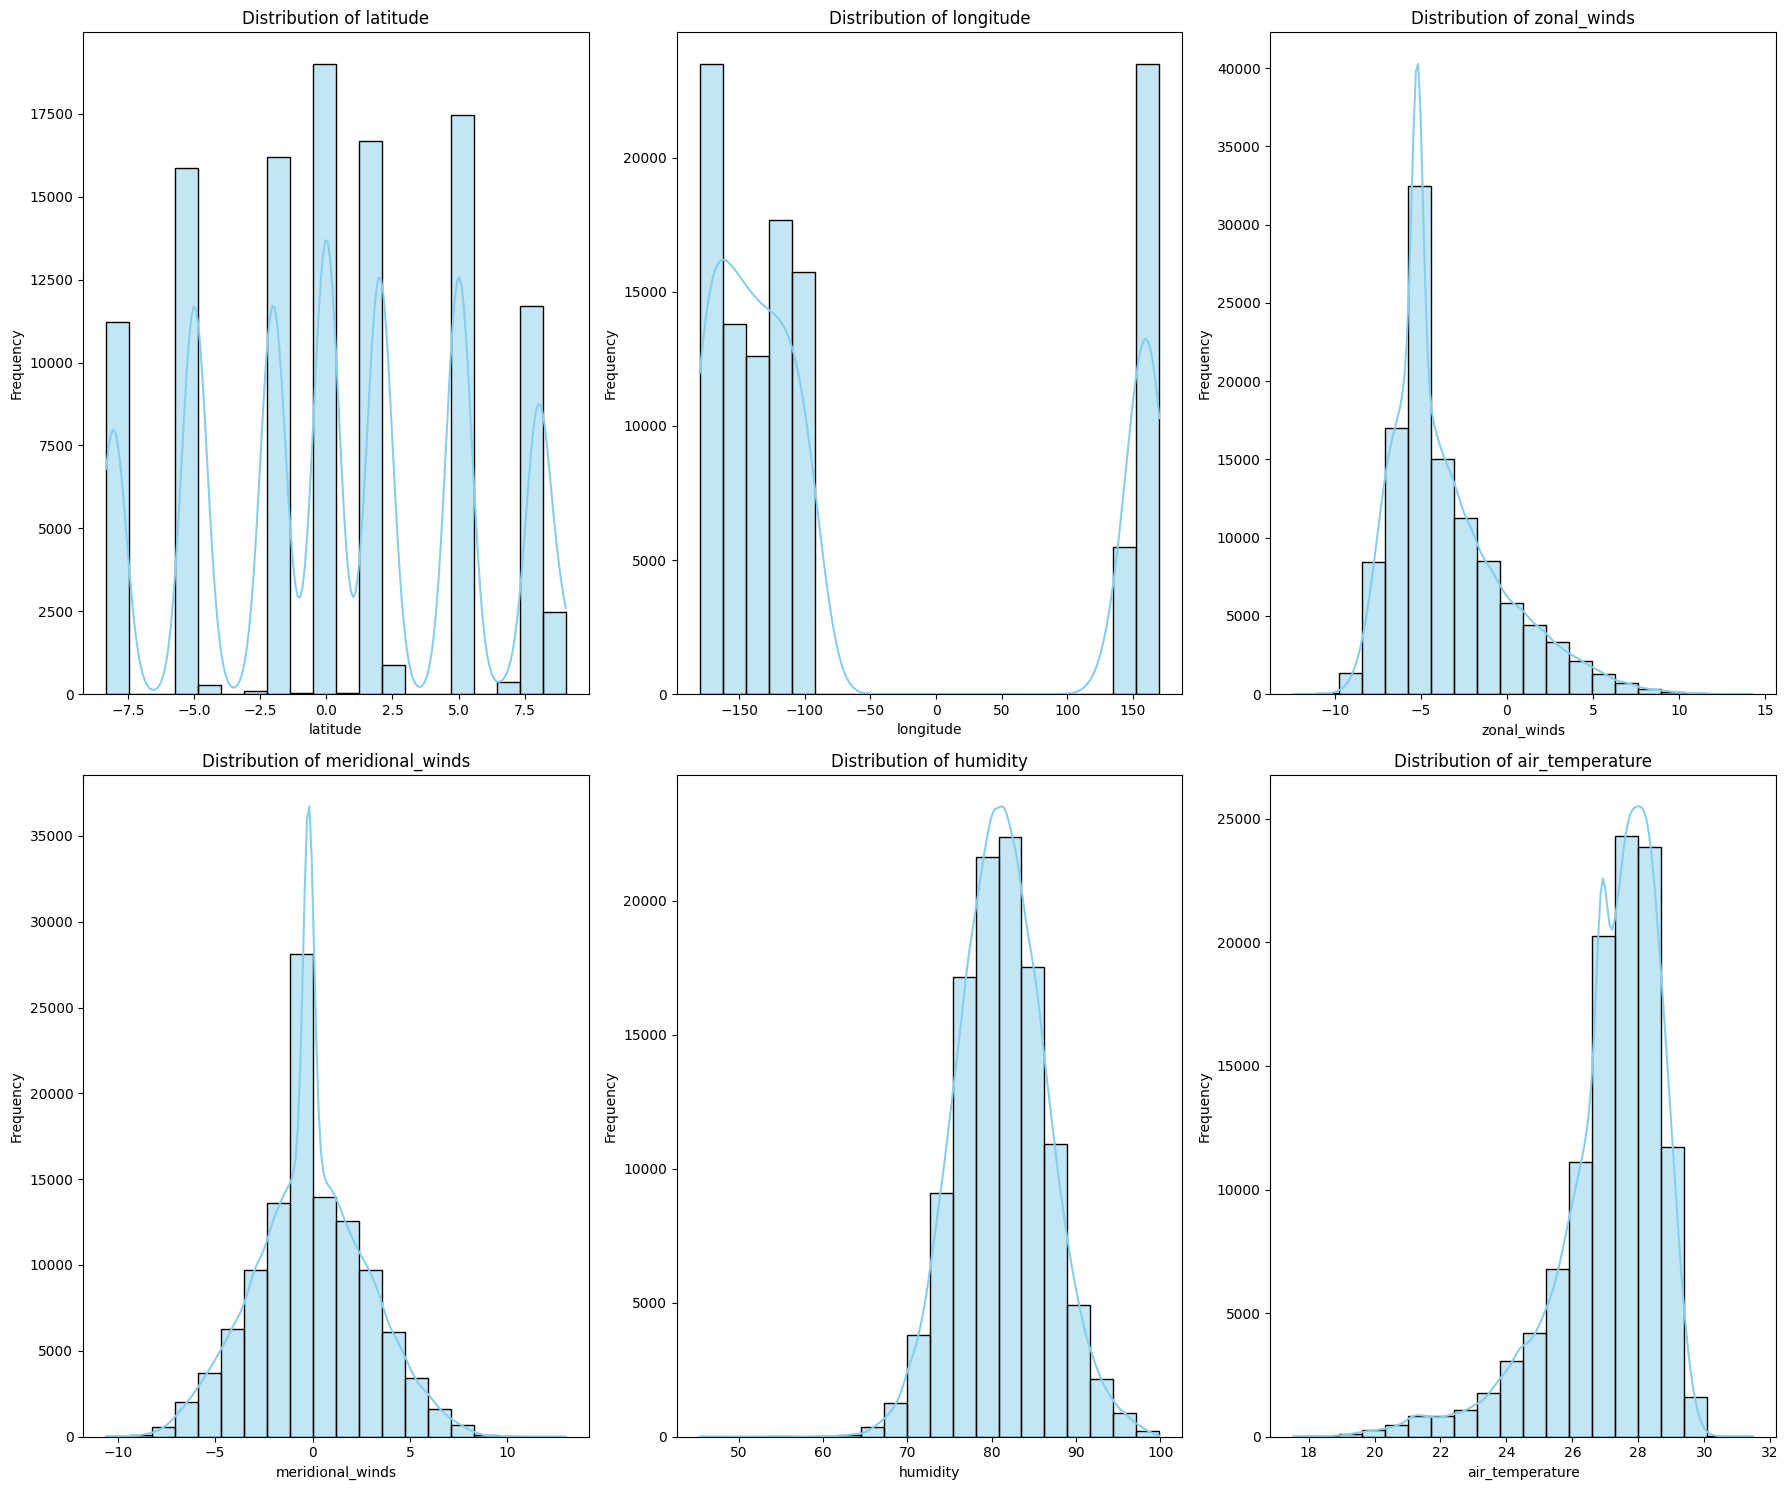

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

df_pandas = df_clean.toPandas()

fig, axes = plt.subplots(2, 3, figsize=(18, 15))
axes = axes.ravel()

columns = ['latitude', 'longitude', 'zonal_winds', 'meridional_winds', 'humidity', 'air_temperature']

for i, col in enumerate(columns):
    sns.histplot(df_pandas[col], kde=True, ax=axes[i], color='skyblue', bins=20)
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

### **4.2. Correlation Plot**

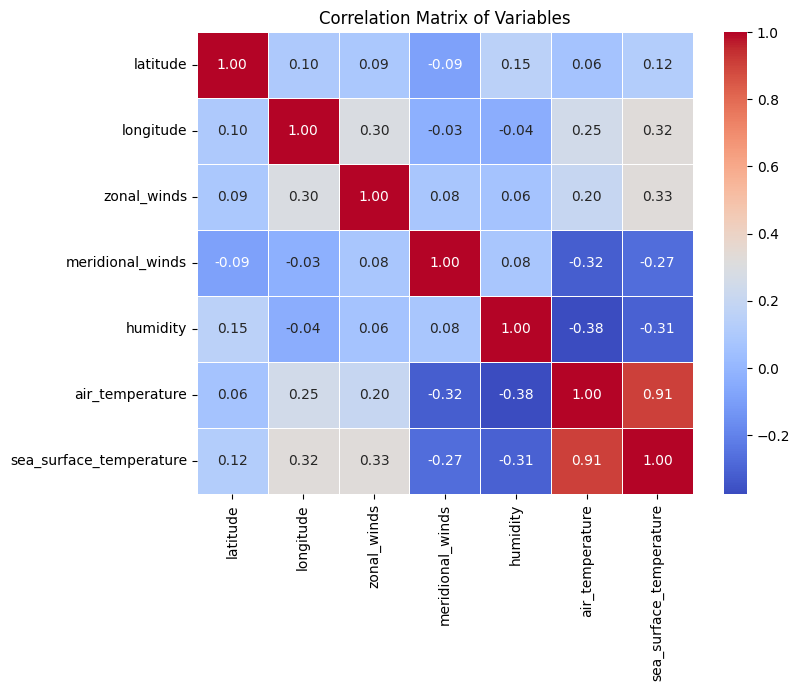

In [17]:
columns = ['latitude', 'longitude', 'zonal_winds', 'meridional_winds', 'humidity', 'air_temperature', 'sea_surface_temperature']
correlation_matrix = df_pandas[columns].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Variables')
plt.show()

### **4.3. Box Plot**

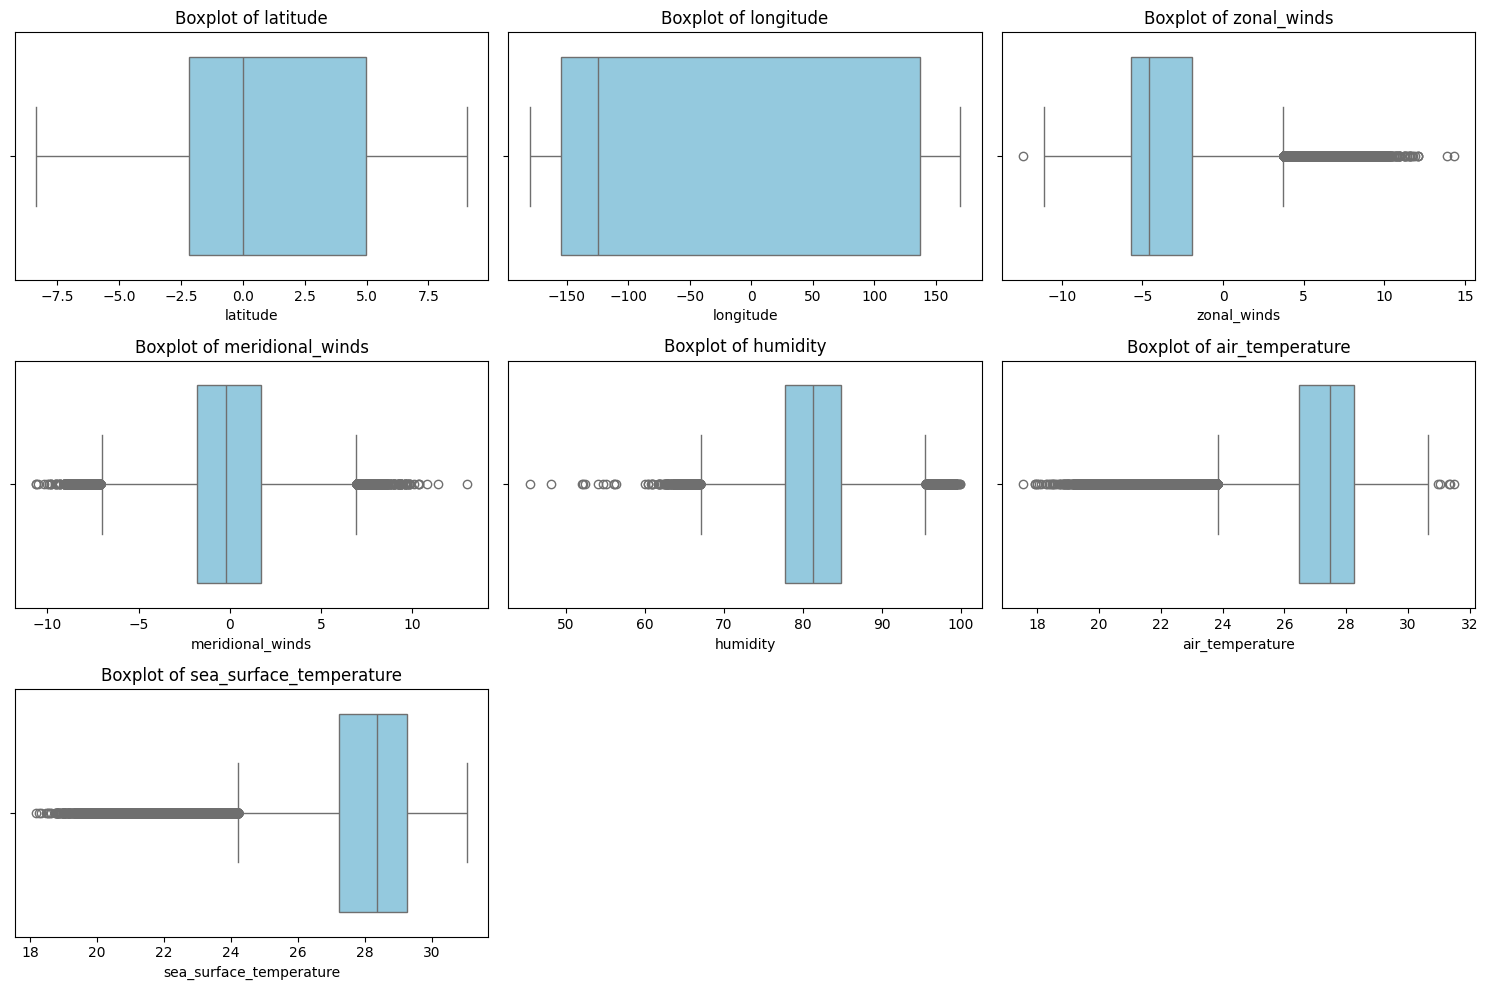

In [18]:
fig, axes = plt.subplots(3,3, figsize=(15, 10))

axes = axes.flatten()

for i, col in enumerate(columns):
    sns.boxplot(x=df_pandas[col], color='skyblue', ax=axes[i]) 
    axes[i].set_title(f'Boxplot of {col}')
    axes[i].set_xlabel(col)

for j in range(len(columns), len(axes)):
    fig.delaxes(axes[j])

# Improve layout
plt.tight_layout()
plt.show()

### **4.4. Distribution of Buoys**

<Axes: title={'center': 'World Distribution of Buoys'}, xlabel='longitude', ylabel='latitude'>

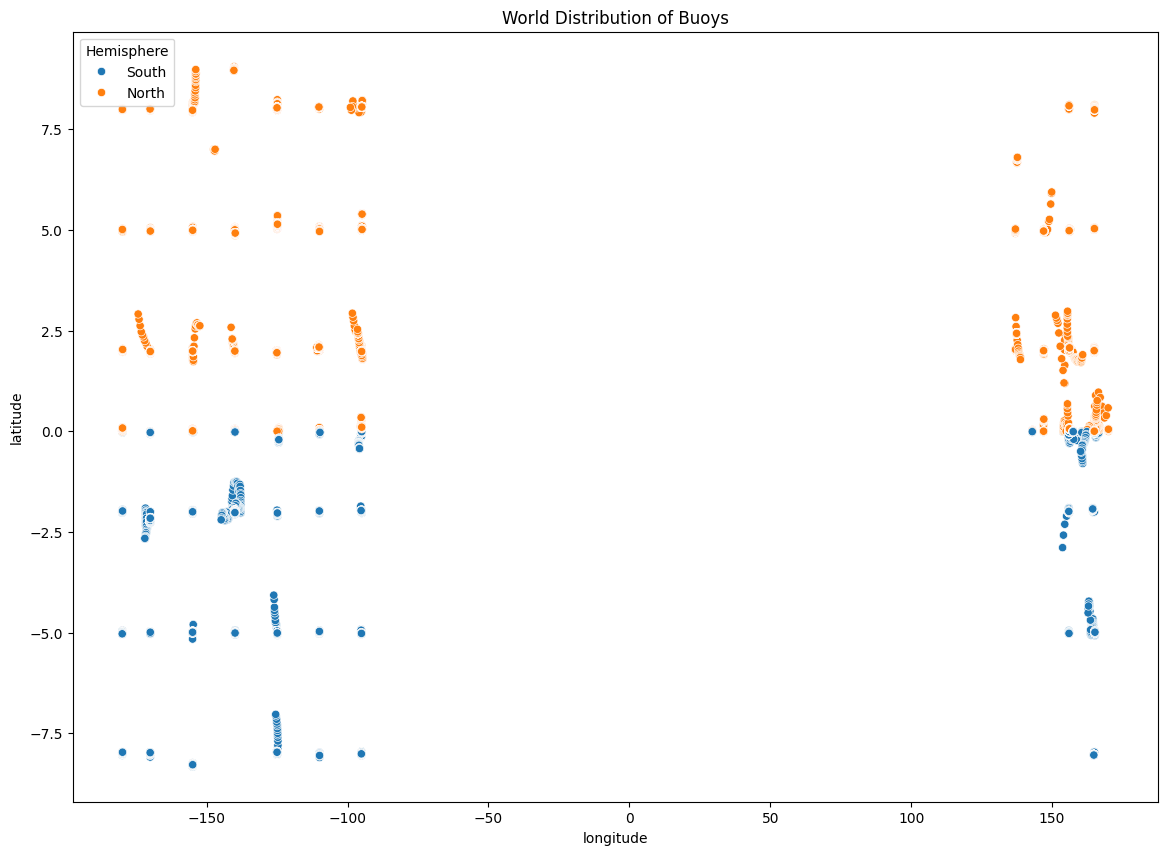

In [19]:
import seaborn as sns

fig = plt.figure(figsize = (14,10))
plt.title('World Distribution of Buoys')
sns.scatterplot(x='longitude',y= 'latitude',data=df_pandas, hue='Hemisphere')

### **4.5. Wind Analysis**

In [20]:
wind_analysis_pd = df_pandas.groupby(['Ocean', 'Hemisphere']).agg(
    Avg_Zonal_Winds=('zonal_winds', 'mean'),
    Avg_Meridional_Winds=('meridional_winds', 'mean')
).reset_index()

print(wind_analysis_pd)


          Ocean Hemisphere  Avg_Zonal_Winds  Avg_Meridional_Winds
0  East Pacific      North        -2.428267              2.087556
1  East Pacific      South        -5.032071              2.224465
2  West Pacific      North        -3.054834             -1.133525
3  West Pacific      South        -2.541788             -0.902180


We will now compare some of the variables between when the El Nino is occured and when El Nino is not occured. We will make subset of the data first.

In [21]:
east_pacific_no_elnino = df.filter((df['Ocean'] == 'East Pacific') & (df['El Nino'] == 'No'))
east_pacific_yes_elnino = df.filter((df['Ocean'] == 'East Pacific') & (df['El Nino'] == 'Yes'))
west_pacific_no_elnino = df.filter((df['Ocean'] == 'West Pacific') & (df['El Nino'] == 'No'))
west_pacific_yes_elnino = df.filter((df['Ocean'] == 'West Pacific') & (df['El Nino'] == 'Yes'))

### **4.6. Sea Temperature Average**

In [22]:
avg_temp_yes_elnino = west_pacific_yes_elnino.agg(F.avg('sea_surface_temperature').alias('avg_temp_yes_elnino')).collect()
avg_temp_no_elnino = west_pacific_no_elnino.agg(F.avg('sea_surface_temperature').alias('avg_temp_no_elnino')).collect()

print(f"Average Sea Surface Temperature in West Pacific (with El Nino): {avg_temp_yes_elnino}")
print(f"Average Sea Surface Temperature in West Pacific (without El Nino): {avg_temp_no_elnino}")

Average Sea Surface Temperature in West Pacific (with El Nino): [Row(avg_temp_yes_elnino=28.9727796310267)]
Average Sea Surface Temperature in West Pacific (without El Nino): [Row(avg_temp_no_elnino=29.122235541836616)]


In [23]:
avg_temp_yes_elnino_east = east_pacific_yes_elnino.agg(F.avg('sea_surface_temperature').alias('avg_temp_yes_elnino')).collect()
avg_temp_no_elnino_east = east_pacific_no_elnino.agg(F.avg('sea_surface_temperature').alias('avg_temp_no_elnino')).collect()

print(f"Average Sea Surface Temperature in East Pacific (with El Nino): {avg_temp_yes_elnino_east}")
print(f"Average Sea Surface Temperature in East Pacific (without El Nino): {avg_temp_no_elnino_east}")

Average Sea Surface Temperature in East Pacific (with El Nino): [Row(avg_temp_yes_elnino=27.965628147390696)]
Average Sea Surface Temperature in East Pacific (without El Nino): [Row(avg_temp_no_elnino=25.321728356014237)]


### **4.7. Zonal Winds Average**

In [24]:
avg_zonal_winds_yes_elnino = west_pacific_yes_elnino.agg(F.avg('zonal_winds').alias('avg_zonal_winds_yes_elnino')).collect()
avg_zonal_winds_no_elnino = west_pacific_no_elnino.agg(F.avg('zonal_winds').alias('avg_zonal_winds_no_elnino')).collect()

print(f"Average Zonal Winds in West Pacific (with El Nino): {avg_zonal_winds_yes_elnino}")
print(f"Average Zonal Winds in West Pacific (without El Nino): {avg_zonal_winds_no_elnino}")

Average Zonal Winds in West Pacific (with El Nino): [Row(avg_zonal_winds_yes_elnino=-1.165280000011921)]
Average Zonal Winds in West Pacific (without El Nino): [Row(avg_zonal_winds_no_elnino=-2.495167275944766)]


In [25]:
avg_zonal_winds_yes_elnino_east = east_pacific_yes_elnino.agg(F.avg('zonal_winds').alias('avg_zonal_winds_yes_elnino')).collect()
avg_zonal_winds_no_elnino_east = east_pacific_no_elnino.agg(F.avg('zonal_winds').alias('avg_zonal_winds_no_elnino')).collect()

print(f"Average Zonal Winds in East Pacific (with El Nino): {avg_zonal_winds_yes_elnino_east}")
print(f"Average Zonal Winds in East Pacific (without El Nino): {avg_zonal_winds_no_elnino_east}")

Average Zonal Winds in East Pacific (with El Nino): [Row(avg_zonal_winds_yes_elnino=-2.8510418888726403)]
Average Zonal Winds in East Pacific (without El Nino): [Row(avg_zonal_winds_no_elnino=-3.6031920492291163)]


## **5. K-Mean Clustering**

In [26]:
from pyspark.ml.feature import VectorAssembler, StandardScaler

cols = ['latitude', 'longitude', 'zonal_winds', 'meridional_winds', 'humidity', 
        'air_temperature', 'sea_surface_temperature']
assembler = VectorAssembler(inputCols=cols, outputCol='features')
df_assembled = assembler.transform(df_clean)


K-means relies on Euclidean distance to measure the similarity between points. If the data have different ranges, the larger-scaled features will dominate the distance computation, which can bias the clustering results.

In [27]:
scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures', withStd=True, withMean=True)
scaler_model = scaler.fit(df_assembled)
df_scaled = scaler_model.transform(df_assembled)

### **5.1. Finding Optimal K**

One of the challenge of kmeans clustering is defining the optimal number of clusters (K). The Elbow Method helps find the optimal number of clusters (K) by evaluating the WSSSE for different K values.

24/12/14 12:45:34 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


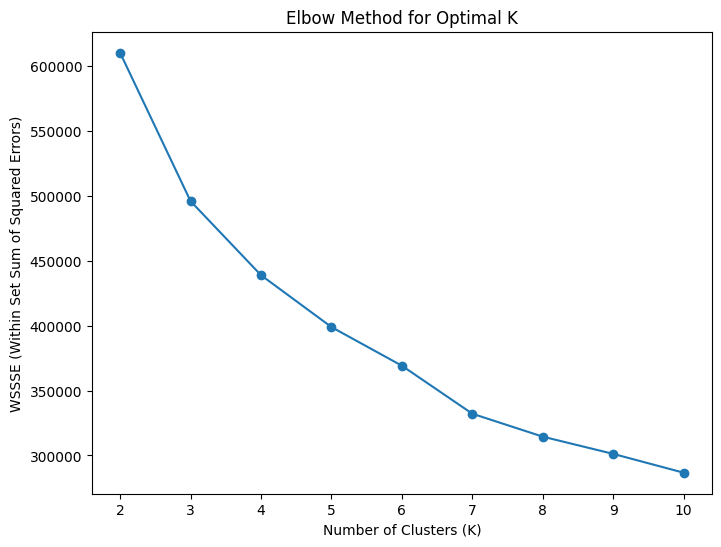

In [28]:
from pyspark.ml.clustering import KMeans

wssse_list = []
for k in range(2, 11):
    kmeans = KMeans(featuresCol='scaledFeatures', predictionCol='cluster', k=k, seed=42)
    kmeans_model = kmeans.fit(df_scaled)
    wssse = kmeans_model.summary.trainingCost
    wssse_list.append(wssse)

plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), wssse_list, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WSSSE (Within Set Sum of Squared Errors)')
plt.title('Elbow Method for Optimal K')
plt.show()

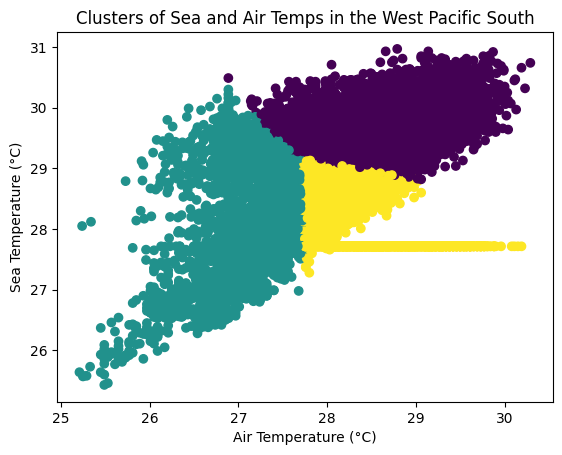

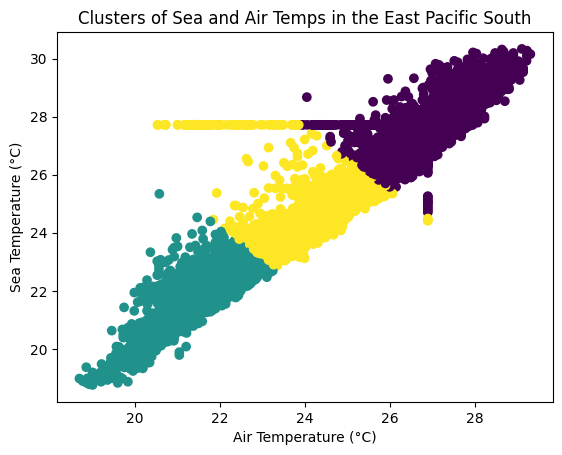

In [32]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
import matplotlib.pyplot as plt

westPacSouth = df_clean.filter((df_clean['Ocean'] == 'West Pacific') & (df_clean['Hemisphere'] == 'South'))
eastPacSouth = df_clean.filter((df_clean['Ocean'] == 'East Pacific') & (df_clean['Hemisphere'] == 'South'))

cols = ["air_temperature", "sea_surface_temperature"]
westPacSouth = westPacSouth.select(*cols)
eastPacSouth = eastPacSouth.select(*cols)

# Assemble features into a vector
assembler = VectorAssembler(inputCols=cols, outputCol="features")
westPacSouth = assembler.transform(westPacSouth)
eastPacSouth = assembler.transform(eastPacSouth)

# Scale features for West Pacific South
scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures', withStd=True, withMean=True)
scaler_model_westPacSouth = scaler.fit(westPacSouth)
westPacSouth = scaler_model_westPacSouth.transform(westPacSouth)

# Scale features for East Pacific South
scaler_model_eastPacSouth = scaler.fit(eastPacSouth)
eastPacSouth = scaler_model_eastPacSouth.transform(eastPacSouth)

# KMeans clustering for West Pacific South
kmeans_westPacSouth = KMeans(k=3, seed=1, featuresCol="scaledFeatures", predictionCol="Cluster")
model_westPacSouth = kmeans_westPacSouth.fit(westPacSouth)
westPacSouth = model_westPacSouth.transform(westPacSouth)

# KMeans clustering for East Pacific South
kmeans_eastPacSouth = KMeans(k=3, seed=1, featuresCol="scaledFeatures", predictionCol="Cluster")
model_eastPacSouth = kmeans_eastPacSouth.fit(eastPacSouth)
eastPacSouth = model_eastPacSouth.transform(eastPacSouth)

# Convert to Pandas DataFrame for visualization
westPacSouth_pd = westPacSouth.select("air_temperature", "sea_surface_temperature", "Cluster").toPandas()
eastPacSouth_pd = eastPacSouth.select("air_temperature", "sea_surface_temperature", "Cluster").toPandas()

# Plot for West Pacific South
plt.scatter(westPacSouth_pd['air_temperature'], westPacSouth_pd['sea_surface_temperature'], c=westPacSouth_pd['Cluster'])
plt.title("Clusters of Sea and Air Temps in the West Pacific South")
plt.xlabel("Air Temperature (°C)")
plt.ylabel("Sea Temperature (°C)")
plt.show()

# Plot for East Pacific South
plt.scatter(eastPacSouth_pd['air_temperature'], eastPacSouth_pd['sea_surface_temperature'], c=eastPacSouth_pd['Cluster'])
plt.title("Clusters of Sea and Air Temps in the East Pacific South")
plt.xlabel("Air Temperature (°C)")
plt.ylabel("Sea Temperature (°C)")
plt.show()

In [33]:
print('West Pacific-specific Clusters')
westPacSouth.groupBy("Cluster").count().show()

print('East Pacific-specific Clusters')
eastPacSouth.groupBy("Cluster").count().show()

West Pacific-specific Clusters
+-------+-----+
|Cluster|count|
+-------+-----+
|      2| 3565|
|      1| 3658|
|      0| 9241|
+-------+-----+

East Pacific-specific Clusters
+-------+-----+
|Cluster|count|
+-------+-----+
|      2| 4172|
|      0| 4708|
|      1| 2373|
+-------+-----+



### **5.2. Silhouette Score**

In [34]:
from pyspark.ml.evaluation import ClusteringEvaluator

evaluator = ClusteringEvaluator(featuresCol='features', predictionCol='Cluster', metricName='silhouette')

silhouette_westPac = evaluator.evaluate(westPacSouth)
print(f"Silhouette Score for West Pacific: {silhouette_westPac}")

silhouette_eastPac = evaluator.evaluate(eastPacSouth)
print(f"Silhouette Score for East Pacific: {silhouette_eastPac}")

Silhouette Score for West Pacific: 0.5318407535433215


Silhouette Score for East Pacific: 0.7232315642145967


## **6. Regression**

### **6.1. Data Separation - Training and Testing**

In [35]:
from pyspark.ml.feature import VectorAssembler

features_columns = ['latitude', 'longitude', 'zonal_winds', 'meridional_winds', 'humidity', 'air_temperature']
target = "sea_surface_temperature"

# Create a VectorAssembler to combine feature columns into a single vector column
assembler = VectorAssembler(inputCols=features_columns, outputCol='features')
df_assembled = assembler.transform(df_clean)

train_data, test_data = df_assembled.randomSplit([0.7, 0.3], seed=42)


In [36]:
train_count = train_data.count()
test_count = test_data.count()

print(f"Number of rows in the training set: {train_count}")
print(f"Number of rows in the test set: {test_count}")

Number of rows in the training set: 78650
Number of rows in the test set: 33669


### **6.2. Linear Regression**

In [37]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

lr = LinearRegression(featuresCol='features', labelCol=target, regParam=0.1)
lr_model = lr.fit(train_data)
predictions = lr_model.transform(test_data)

evaluator = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})

print(f"Linear Regression RMSE: {rmse}")
print(f"Linear Regression R^2: {r2}")

24/12/14 12:53:52 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


Linear Regression RMSE: 0.6997383861495942
Linear Regression R^2: 0.8459116065150543


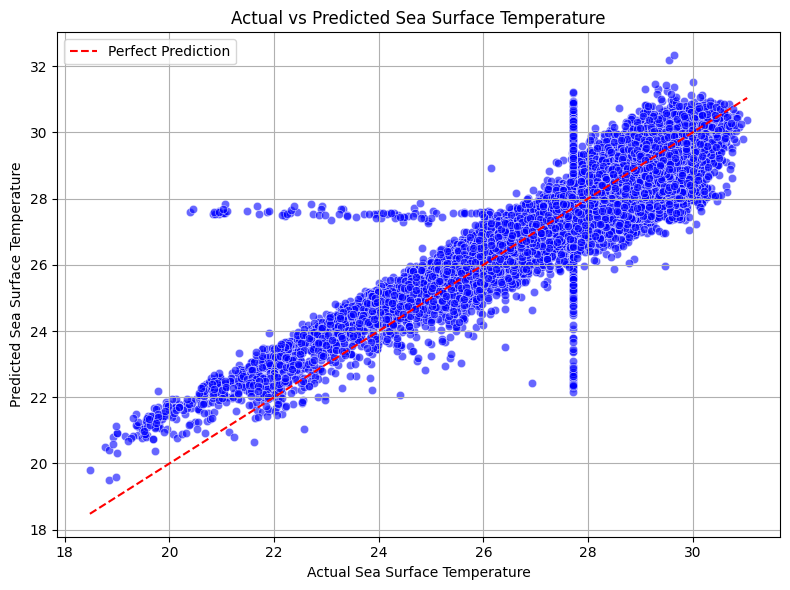

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

y_actual = predictions.select(target).toPandas()
y_pred = predictions.select("prediction").toPandas()

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_actual[target], y=y_pred['prediction'], color='blue', alpha=0.6)
plt.title('Actual vs Predicted Sea Surface Temperature')
plt.xlabel('Actual Sea Surface Temperature')
plt.ylabel('Predicted Sea Surface Temperature')

plt.plot([y_actual[target].min(), y_actual[target].max()], 
         [y_actual[target].min(), y_actual[target].max()], color='red', linestyle='--', label='Perfect Prediction')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


### **6.3. Decision Tree**

In [39]:
from pyspark.ml.regression import DecisionTreeRegressor

dt = DecisionTreeRegressor(featuresCol='features', labelCol=target)
dt_model = dt.fit(train_data)
dt_predictions = dt_model.transform(test_data)
dt_rmse = evaluator.evaluate(dt_predictions)
dt_r2 = evaluator.evaluate(dt_predictions, {evaluator.metricName: "r2"})

print(f"Decision Tree RMSE: {dt_rmse}")
print(f"Decision Tree R^2: {dt_r2}")


Decision Tree RMSE: 0.670769183392831
Decision Tree R^2: 0.8584060383254946


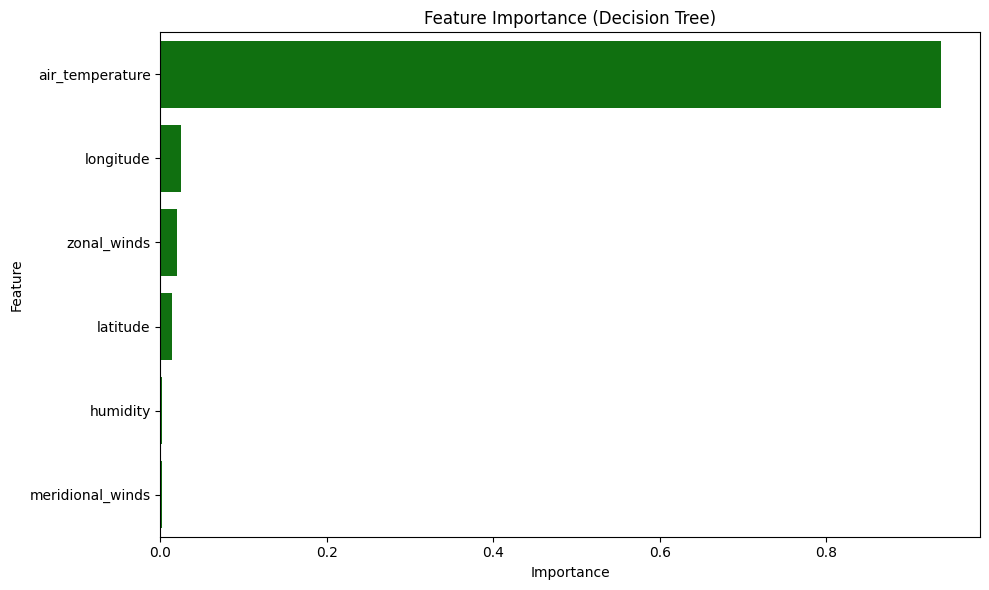

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

feature_importances = dt_model.featureImportances.toArray() 
assert len(features_columns) == len(feature_importances), "Number of features does not match the number of feature importances."

importance_df = pd.DataFrame({
    'Feature': features_columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, color='green')
plt.title('Feature Importance (Decision Tree)')
plt.tight_layout()
plt.show()

### **6.4. Random Forest Regression**

In [41]:
from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(featuresCol='features', labelCol=target)
rf_model = rf.fit(train_data)
rf_predictions = rf_model.transform(test_data)

rf_rmse = evaluator.evaluate(rf_predictions)
rf_r2 = evaluator.evaluate(rf_predictions, {evaluator.metricName: "r2"})

print(f"Random Forest RMSE: {rf_rmse}")
print(f"Random Forest R^2: {rf_r2}")

Random Forest RMSE: 0.7183029544775157
Random Forest R^2: 0.8376269925490906


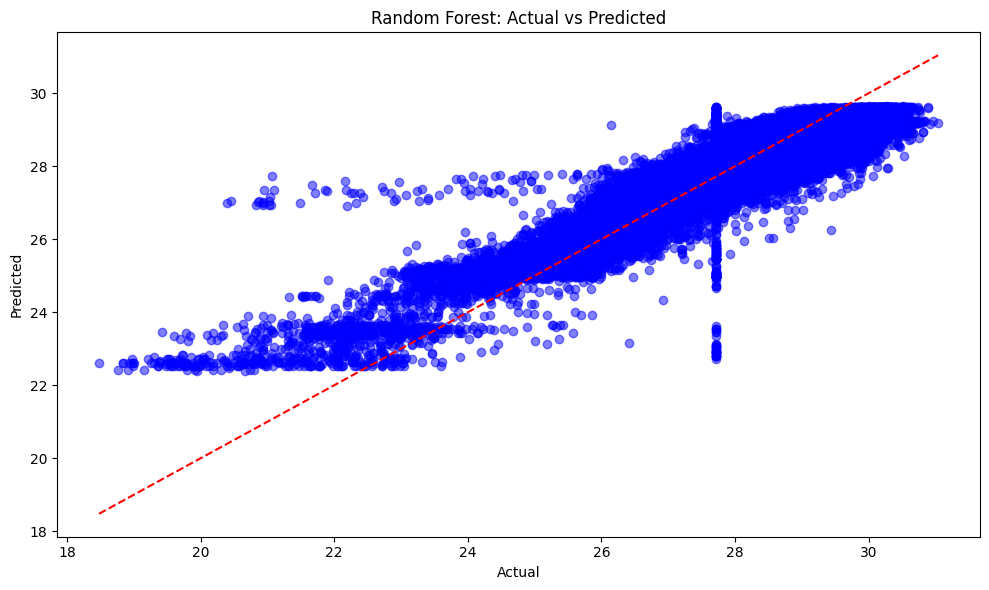

In [45]:
predictions_data = rf_predictions.select('prediction', target).toPandas()

plt.figure(figsize=(10, 6))
plt.scatter(predictions_data[target], predictions_data['prediction'], color='blue', alpha=0.5)
plt.plot([min(predictions_data[target]), max(predictions_data[target])], 
         [min(predictions_data[target]), max(predictions_data[target])], color='red', linestyle='--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Random Forest: Actual vs Predicted')
plt.tight_layout()
plt.show()


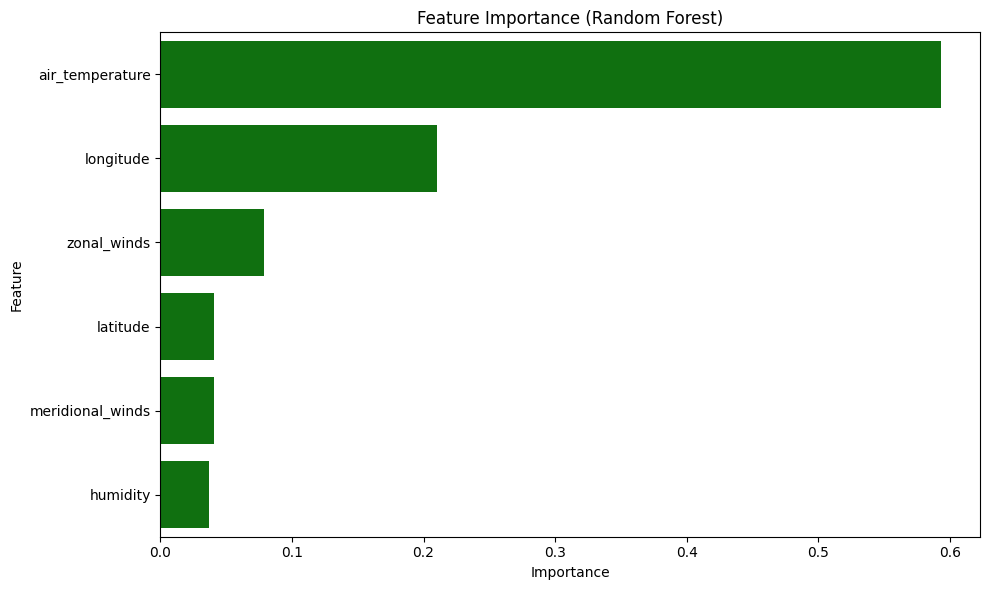

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

feature_importances = rf_model.featureImportances.toArray()
assert len(features_columns) == len(feature_importances), "Number of features does not match the number of feature importances."

importance_df = pd.DataFrame({
    'Feature': features_columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, color='green')
plt.title('Feature Importance (Random Forest)')
plt.tight_layout()
plt.show()

In [46]:
from pyspark.sql.types import StructType, StructField, StringType, DoubleType
from pyspark.sql.functions import round

schema = StructType([
    StructField("Model", StringType(), True),
    StructField("RMSE", DoubleType(), True)
])

data = [
    ("Linear Regression", rmse),
    ("Decision Tree", dt_rmse),
    ("Random Forest", rf_rmse)
]

results_df = spark.createDataFrame(data, schema=schema)
results_df = results_df.withColumn("RMSE", round(results_df["RMSE"], 2))

results_df.show()


+-----------------+----+
|            Model|RMSE|
+-----------------+----+
|Linear Regression| 0.7|
|    Decision Tree|0.67|
|    Random Forest|0.72|
+-----------------+----+



## **Perform with Hyperparameter Tuning**

### **6.5. Linear Regression - Hyperparameter Tuning**

In [47]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

lr_paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

lr_crossval = CrossValidator(estimator=lr,
                             estimatorParamMaps=lr_paramGrid,
                             evaluator=evaluator,
                             numFolds=3)

lr_cvModel = lr_crossval.fit(train_data)
lr_predictions = lr_cvModel.transform(test_data)
lr_rmse = evaluator.evaluate(lr_predictions)
print(f"Best Linear Regression RMSE: {lr_rmse}")


Best Linear Regression RMSE: 0.6952518542987701


In [48]:
best_lr_model = lr_cvModel.bestModel

best_regParam = best_lr_model._java_obj.getRegParam()
best_elasticNetParam = best_lr_model._java_obj.getElasticNetParam()

print(f"Best regParam: {best_regParam}")
print(f"Best elasticNetParam: {best_elasticNetParam}")

Best regParam: 0.01
Best elasticNetParam: 0.0


### **6.6. Decision Tree - Hyperparameter Tuning**

In [49]:
dt_paramGrid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [5, 10]) \
    .addGrid(dt.maxBins, [16, 32, 64]) \
    .build()

dt_crossval = CrossValidator(estimator=dt,
                             estimatorParamMaps=dt_paramGrid,
                             evaluator=evaluator,
                             numFolds=3)

dt_cvModel = dt_crossval.fit(train_data)

dt_predictions = dt_cvModel.transform(test_data)
dt_rmse = evaluator.evaluate(dt_predictions)
print(f"Decision Tree Regression RMSE: {dt_rmse}")

Decision Tree Regression RMSE: 0.5585941957207795


In [50]:
best_dt_model = dt_cvModel.bestModel

best_maxDepth = best_dt_model._java_obj.getMaxDepth()
best_maxBins = best_dt_model._java_obj.getMaxBins()

print(f"Best maxDepth: {best_maxDepth}")
print(f"Best maxBins: {best_maxBins}")

Best maxDepth: 10
Best maxBins: 32


### **6.7. Random Forest - Hyperparameter Tuning**

In [51]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

rf_paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20]) \
    .addGrid(rf.maxDepth, [5, 10]) \
    .addGrid(rf.maxBins, [16, 32]) \
    .build()

rf_crossval = CrossValidator(estimator=rf,
                             estimatorParamMaps=rf_paramGrid,
                             evaluator=evaluator,
                             numFolds=3)

rf_cvModel = rf_crossval.fit(train_data)

rf_predictions = rf_cvModel.transform(test_data)
rf_rmse = evaluator.evaluate(rf_predictions)
print(f"Random Forest Regression RMSE: {rf_rmse}")

best_rf_model = rf_cvModel.bestModel
print(f"Best numTrees: {best_rf_model.getNumTrees}")
print(f"Best maxDepth: {best_rf_model.getMaxDepth()}")
print(f"Best maxBins: {best_rf_model.getMaxBins()}")


24/12/14 12:56:36 WARN DAGScheduler: Broadcasting large task binary with size 1469.1 KiB
24/12/14 12:56:39 WARN DAGScheduler: Broadcasting large task binary with size 1448.6 KiB
24/12/14 12:56:45 WARN DAGScheduler: Broadcasting large task binary with size 1555.8 KiB
24/12/14 12:56:46 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/12/14 12:56:50 WARN DAGScheduler: Broadcasting large task binary with size 1578.8 KiB
24/12/14 12:56:51 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/12/14 12:57:00 WARN DAGScheduler: Broadcasting large task binary with size 1461.1 KiB
24/12/14 12:57:04 WARN DAGScheduler: Broadcasting large task binary with size 1479.6 KiB
24/12/14 12:57:15 WARN DAGScheduler: Broadcasting large task binary with size 1569.3 KiB
24/12/14 12:57:16 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/12/14 12:57:23 WARN DAGScheduler: Broadcasting large task binary with size 1583.5 KiB
24/12/14 12:57:24 WARN DAGSche

Random Forest Regression RMSE: 0.5391365745575395
Best numTrees: 20
Best maxDepth: 10
Best maxBins: 32


## **7. Conclusion**

### **7.1. Regression Performance Comparison**

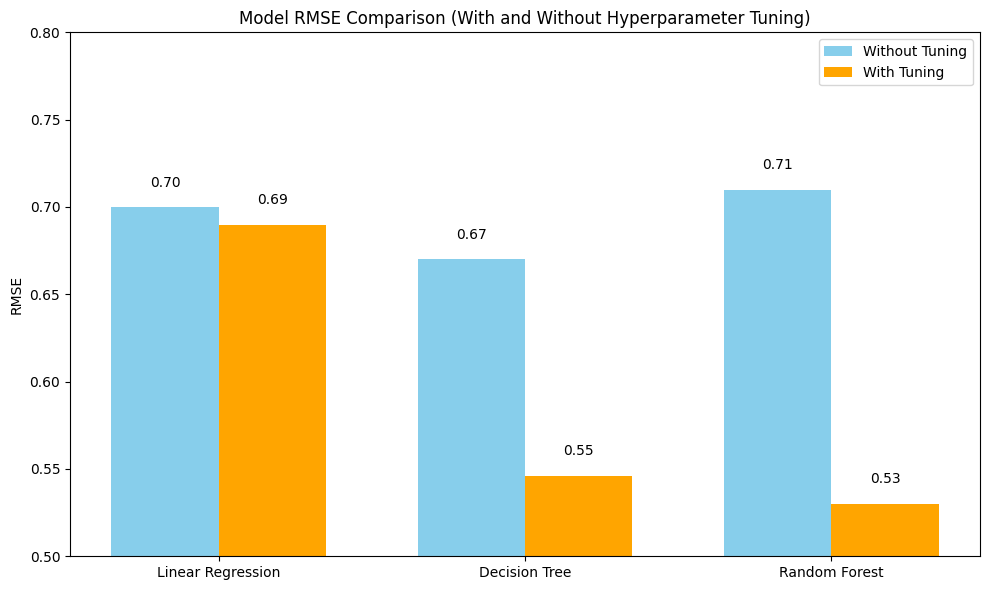

In [55]:
import matplotlib.pyplot as plt
import numpy as np

models = ['Linear Regression', 'Decision Tree', 'Random Forest']
rmse_no_tuning = [0.7, 0.67, 0.71]
rmse_with_tuning = [0.6899, 0.5460, 0.53]  

x = np.arange(len(models))
plt.figure(figsize=(10, 6))
bar_width = 0.35

bars1 = plt.bar(x - bar_width / 2, rmse_no_tuning, width=bar_width, label='Without Tuning', color='skyblue')
bars2 = plt.bar(x + bar_width / 2, rmse_with_tuning, width=bar_width, label='With Tuning', color='orange')

for bar in bars1:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{bar.get_height():.2f}', ha='center', va='bottom')

for bar in bars2:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{bar.get_height():.2f}', ha='center', va='bottom')

plt.xticks(x, models)
plt.ylabel('RMSE')
plt.title('Model RMSE Comparison (With and Without Hyperparameter Tuning)')
plt.legend()
plt.ylim(0.5, 0.8) 

plt.tight_layout()
plt.show()
